In [123]:
pip install image_similarity_measures


In [124]:
from keras.datasets import mnist, cifar10
from keras.models import Sequential, load_model
from keras.layers.core import Activation
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from keras.utils import np_utils
from time import time
import cv2
from keras.layers import Dense,Dropout,Flatten,Conv2D,MaxPooling2D
from keras.constraints import maxnorm
from keras.optimizers import SGD
from keras import backend as K 
from keras.layers import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint
import image_similarity_measures
from image_similarity_measures.quality_metrics import rmse, ssim, sre, issm, sam, uiq, fsim, psnr

np.random.seed(100)

In [125]:
def preprocess(dataset='mnist'):
  if (dataset == 'mnist'):
    (X_train, y_train), (X_test, y_test) = mnist.load_data()
    X_train = X_train / 255
    X_test = X_test / 255
    X_train_Flatten = X_train.reshape(len(X_train), X_train[0].shape[0]*X_train[0].shape[1])
    X_test_Flatten = X_test.reshape(len(X_test), X_train[0].shape[0]*X_train[0].shape[1])
    X_train = X_train.astype('float32')
    X_test = X_test.astype('float32')
    y_test = np_utils.to_categorical(y_test, 10)
    y_train = np_utils.to_categorical(y_train, 10)
  else:
    (X_train, y_train), (X_test, y_test) = cifar10.load_data()
    X_train = X_train / 255
    X_test = X_test / 255
    X_train_Flatten = X_train.reshape(len(X_train), X_train[0].shape[0]*X_train[0].shape[1]*X_train[0].shape[2])
    X_test_Flatten = X_test.reshape(len(X_test), X_train[0].shape[0]*X_train[0].shape[1]*X_train[0].shape[2])
    X_train = X_train.astype('float32')
    X_test = X_test.astype('float32')
    y_test = np_utils.to_categorical(y_test, 10)
    y_train = np_utils.to_categorical(y_train, 10)
  return (X_train, y_train), (X_test, y_test), (X_train_Flatten, X_test_Flatten)


In [208]:
class Fuzzer:
  def __init__(self, epsilon, image, imageLabel, model, modelType, dataset):
    self.model = model
    self.modelType = modelType
    self.epsilon = epsilon
    self.image = image
    self.flattenImage = self.image.flatten()
    self.imageShape = self.image.shape
    self.imageFlattenedShape = self.flattenImage.shape
    self.modifiedImage = self.image
    self.modifiedFlattenImage = self.flattenImage
    self.imageLabel = imageLabel
    self.time = 0
    self.t1 = 0
    self.t2 = 0
    self.dataset = dataset

  def randomDirection(self):
    pass 

  def generate(self):
    self.t1 = time()
    for i in (range(50000)):
      self.randomDirection()
      if self.modelType == 'ANN':
        if self.dataset == 'mnist':
          newID = np.argmax(self.model.predict(self.modifiedFlattenImage.reshape(-1, 784)))
        else:
          newID = np.argmax(self.model.predict(self.modifiedFlattenImage.reshape(-1, 3072)))
        oldID = np.argmax(self.imageLabel)
      else:
        if self.dataset == 'cifar10':
          sh = (1, 32, 32, 3)
        else:
          sh = (1, 28, 28, 1)
        newID = np.argmax(self.model.predict(np.reshape(self.modifiedImage, newshape=sh)))
        oldID = np.argmax(self.imageLabel)
      if (newID != oldID):
        print(f'We found it in iteration number {i}')
        print(f"new ID: {newID}")
        print(f"old ID: {oldID}")
      
        self.t2 = time()
        self.time= self.t2 - self.t1
        break
  def plot(self, fuzzerName):
    fig = plt.figure()
    fig.suptitle(f"{fuzzerName}", fontsize=16)
    plt.subplot(1,2,1)
    plt.tight_layout()
    plt.imshow(self.modifiedImage)
    plt.title(f"My new distorted picture")
    plt.subplot(1,2,2)
    plt.tight_layout()
    plt.imshow(self.image)
    plt.title(f"My original picture")


class CompeletlyRandom(Fuzzer):
  def randomDirection(self):
    vec = np.random.randint(-1, 2, self.imageFlattenedShape)
    self.modifiedFlattenImage += self.epsilon * vec
    self.modifiedFlattenImage = np.clip(self.modifiedFlattenImage, 0, 1)

    self.modifiedImage = np.reshape(self.modifiedFlattenImage, self.imageShape)

class laplaceRandom(Fuzzer):
  def randomDirection(self):
    vec = np.random.laplace(0, self.epsilon, self.imageFlattenedShape)
    self.modifiedFlattenImage += vec
    self.modifiedFlattenImage = np.clip(self.modifiedFlattenImage, 0, 1)

    self.modifiedImage = np.reshape(self.modifiedFlattenImage, self.imageShape)

class normalRandom(Fuzzer):
  def randomDirection(self):
    vec = np.random.normal(0, self.epsilon, self.imageFlattenedShape)
    self.modifiedFlattenImage += vec
    self.modifiedFlattenImage = np.clip(self.modifiedFlattenImage, 0, 1)

    self.modifiedImage = np.reshape(self.modifiedFlattenImage, self.imageShape)

class gumbelRandom(Fuzzer):
  def randomDirection(self):
    vec = np.random.gumbel(0, self.epsilon, self.imageFlattenedShape)
    self.modifiedFlattenImage += vec
    self.modifiedFlattenImage = np.clip(self.modifiedFlattenImage, 0, 1)

    self.modifiedImage = np.reshape(self.modifiedFlattenImage, self.imageShape)


class CompeletlyRandomSSIM(Fuzzer):
  def __init__(self, epsilon, image, imageLabel, model, modelType, dataset):
    super().__init__(epsilon= epsilon, image= image, imageLabel = imageLabel, model = model, modelType = modelType, dataset =dataset)
    self.similarity1 = 1
    self.similarity2 = 0
  
  def randomDirection(self):
    while (1):
      vec = np.random.randint(-1, 2, self.imageFlattenedShape)
      tempImageTrueSize = self.modifiedImage
      tempImageFlatten = self.modifiedFlattenImage
      self.modifiedFlattenImage += self.epsilon * vec
      self.modifiedFlattenImage = np.clip(self.modifiedFlattenImage, 0, 1)

      self.modifiedImage = np.reshape(self.modifiedFlattenImage, self.imageShape)
      self.similarity2 = ssim(self.modifiedImage, self.image)

      if self.similarity2 > self.similarity1:
        self.modifiedImage = tempImageTrueSize
        self.modifiedFlattenImage = tempImageFlatten
        continue
      else:
        self.similarity1 = self.similarity2
        break
  

class laplaceRandomSSIM(Fuzzer):
  def __init__(self, epsilon, image, imageLabel, model, modelType, dataset):
    super().__init__(epsilon= epsilon, image= image, imageLabel = imageLabel, model = model, modelType = modelType, dataset = dataset)
    self.similarity1 = 1
    self.similarity2 = 0
  
  def randomDirection(self):
    while (1):
      vec = np.random.laplace(0, self.epsilon, self.imageFlattenedShape)
      tempImageTrueSize = self.modifiedImage
      tempImageFlatten = self.modifiedFlattenImage
      self.modifiedFlattenImage += vec
      self.modifiedFlattenImage = np.clip(self.modifiedFlattenImage, 0, 1)

      self.modifiedImage = np.reshape(self.modifiedFlattenImage, self.imageShape)
      self.similarity2 = ssim(self.modifiedImage, self.image)

      if self.similarity2 > self.similarity1:
        self.modifiedImage = tempImageTrueSize
        self.modifiedFlattenImage = tempImageFlatten
        continue
      else:
        self.similarity1 = self.similarity2
        break

class normalRandomSSIM(Fuzzer):
  def __init__(self, epsilon, image, imageLabel, model, modelType, dataset):
    super().__init__(epsilon= epsilon, image= image, imageLabel = imageLabel, model = model, modelType = modelType, dataset = dataset)
    self.similarity1 = 1
    self.similarity2 = 0
  
  def randomDirection(self):
    while (1):
      vec = np.random.normal(0, self.epsilon, self.imageFlattenedShape)
      tempImageTrueSize = self.modifiedImage
      tempImageFlatten = self.modifiedFlattenImage
      self.modifiedFlattenImage += vec
      self.modifiedFlattenImage = np.clip(self.modifiedFlattenImage, 0, 1)

      self.modifiedImage = np.reshape(self.modifiedFlattenImage, self.imageShape)
      self.similarity2 = ssim(self.modifiedImage, self.image)

      if self.similarity2 > self.similarity1:
        self.modifiedImage = tempImageTrueSize
        self.modifiedFlattenImage = tempImageFlatten
        continue
      else:
        self.similarity1 = self.similarity2
        break

class gumbelRandomSSIM(Fuzzer):
  def __init__(self, epsilon, image, imageLabel, model, modelType, dataset):
    super().__init__(epsilon= epsilon, image= image, imageLabel = imageLabel, model = model, modelType = modelType, dataset= dataset)
    self.similarity1 = 1
    self.similarity2 = 0
  
  def randomDirection(self):
    while (1):
      vec = np.random.gumbel(0, self.epsilon, self.imageFlattenedShape)
      tempImageTrueSize = self.modifiedImage
      tempImageFlatten = self.modifiedFlattenImage
      self.modifiedFlattenImage += vec
      self.modifiedFlattenImage = np.clip(self.modifiedFlattenImage, 0, 1)

      self.modifiedImage = np.reshape(self.modifiedFlattenImage, self.imageShape)
      self.similarity2 = ssim(self.modifiedImage, self.image)

      if self.similarity2 > self.similarity1:
        self.modifiedImage = tempImageTrueSize
        self.modifiedFlattenImage = tempImageFlatten
        continue
      else:
        self.similarity1 = self.similarity2
        break

class gumbelRandomPSNR(Fuzzer):
  def __init__(self, epsilon, image, imageLabel, model, modelType, dataset):
    super().__init__(epsilon= epsilon, image= image, imageLabel = imageLabel, model = model, modelType = modelType, dataset = dataset)
    self.similarity1 = 1
    self.similarity2 = 0
  
  def randomDirection(self):
    while (1):
      vec = np.random.gumbel(0, self.epsilon, self.imageFlattenedShape)
      tempImageTrueSize = self.modifiedImage
      tempImageFlatten = self.modifiedFlattenImage
      self.modifiedFlattenImage += vec
      self.modifiedFlattenImage = np.clip(self.modifiedFlattenImage, 0, 1)

      self.modifiedImage = np.reshape(self.modifiedFlattenImage, self.imageShape)
      self.similarity2 = rmse(self.modifiedImage, self.image)

      if self.similarity2 > self.similarity1:
        self.modifiedImage = tempImageTrueSize
        self.modifiedFlattenImage = tempImageFlatten
        continue
      else:
        self.similarity1 = self.similarity2
        break

In [210]:
(X_train, y_train), (X_test, y_test), (X_train_Flatten, X_test_Flatten) = preprocess('mnist')

In [128]:
model_mnist_ann = load_model("model_mnist_ann.h5")

Gumbel random fuzzer + SSIM:
We found it in iteration number 26
new ID: 8
old ID: 7
It took us 2.1366021633148193 seconds
-------------------------------------------------------
Normal random fuzzer + SSIM:
We found it in iteration number 267
new ID: 8
old ID: 7
It took us 13.469717502593994 seconds
-------------------------------------------------------
Laplace random fuzzer + SSIM:
We found it in iteration number 141
new ID: 8
old ID: 7
It took us 7.142368316650391 seconds
-------------------------------------------------------
Compeletly random fuzzer + SSIM:
We found it in iteration number 311
new ID: 8
old ID: 7
It took us 15.996229648590088 seconds
-------------------------------------------------------


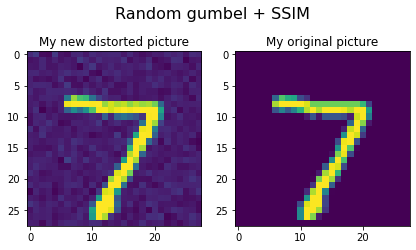

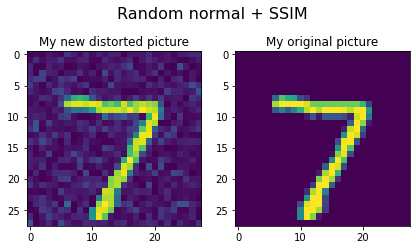

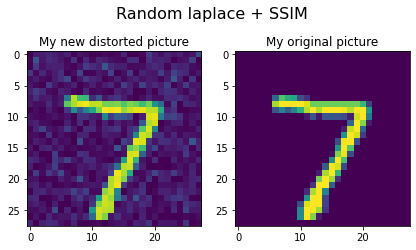

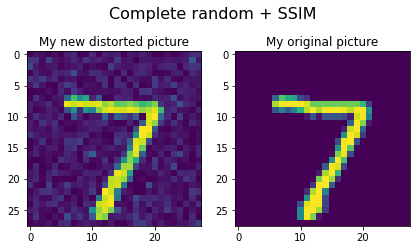

In [129]:
print("Gumbel random fuzzer + SSIM:")
myFuzz = gumbelRandomSSIM(0.005, X_test[0], y_test[0], model_mnist_ann, 'ANN', 'mnist')
myFuzz.generate()
print(f"It took us {myFuzz.time} seconds")
myFuzz.plot("Random gumbel + SSIM")
print("-------------------------------------------------------")
print("Normal random fuzzer + SSIM:")
myFuzz = normalRandomSSIM(0.005, X_test[0].copy(), y_test[0], model_mnist_ann, 'ANN', 'mnist')
myFuzz.generate()
print(f"It took us {myFuzz.time} seconds")
myFuzz.plot("Random normal + SSIM")
print("-------------------------------------------------------")
print("Laplace random fuzzer + SSIM:")
myFuzz = laplaceRandomSSIM(0.005, X_test[0].copy(), y_test[0], model_mnist_ann, 'ANN', 'mnist')
myFuzz.generate()
print(f"It took us {myFuzz.time} seconds")
myFuzz.plot("Random laplace + SSIM")
print("-------------------------------------------------------")
print("Compeletly random fuzzer + SSIM:")
myFuzz = CompeletlyRandomSSIM(0.005, X_test[0].copy(), y_test[0], model_mnist_ann, 'ANN', 'mnist')
myFuzz.generate()
print(f"It took us {myFuzz.time} seconds")
myFuzz.plot("Complete random + SSIM")
print("-------------------------------------------------------")

In [106]:
model_mnist_cnn = load_model("model_mnist_cnn.h5")

Gumbel random fuzzer + SSIM:
We found it in iteration number 53
new ID: 8
old ID: 7
It took us 3.285964012145996 seconds
-------------------------------------------------------
Normal random fuzzer + SSIM:
We found it in iteration number 746
new ID: 8
old ID: 7
It took us 42.08117961883545 seconds
-------------------------------------------------------
Laplace random fuzzer + SSIM:
We found it in iteration number 416
new ID: 8
old ID: 7
It took us 22.720534086227417 seconds
-------------------------------------------------------
Compeletly random fuzzer + SSIM:
We found it in iteration number 773
new ID: 8
old ID: 7
It took us 44.7309091091156 seconds
-------------------------------------------------------


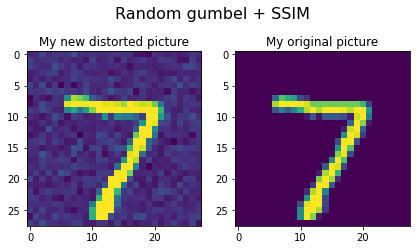

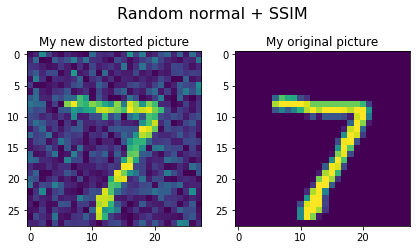

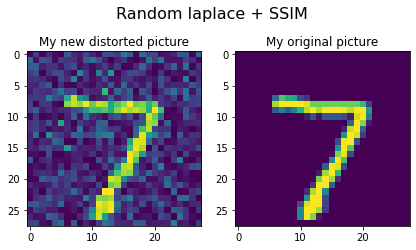

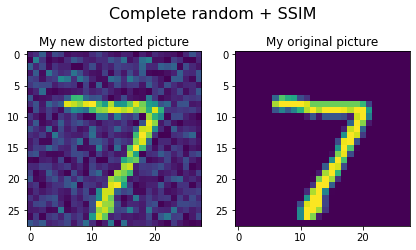

In [107]:
print("Gumbel random fuzzer + SSIM:")
myFuzz = gumbelRandomSSIM(0.005, X_test[0], y_test[0], model_mnist_cnn, 'CNN', 'mnist')
myFuzz.generate()
print(f"It took us {myFuzz.time} seconds")
myFuzz.plot("Random gumbel + SSIM")
print("-------------------------------------------------------")
print("Normal random fuzzer + SSIM:")
myFuzz = normalRandomSSIM(0.005, X_test[0].copy(), y_test[0], model_mnist_cnn, 'CNN', 'mnist')
myFuzz.generate()
print(f"It took us {myFuzz.time} seconds")
myFuzz.plot("Random normal + SSIM")
print("-------------------------------------------------------")
print("Laplace random fuzzer + SSIM:")
myFuzz = laplaceRandomSSIM(0.005, X_test[0].copy(), y_test[0], model_mnist_cnn, 'CNN', 'mnist')
myFuzz.generate()
print(f"It took us {myFuzz.time} seconds")
myFuzz.plot("Random laplace + SSIM")
print("-------------------------------------------------------")
print("Compeletly random fuzzer + SSIM:")
myFuzz = CompeletlyRandomSSIM(0.005, X_test[0].copy(), y_test[0], model_mnist_cnn, 'CNN', 'mnist')
myFuzz.generate()
print(f"It took us {myFuzz.time} seconds")
myFuzz.plot("Complete random + SSIM")
print("-------------------------------------------------------")

Gumbel random fuzzer + ISSM:
We found it in iteration number 48
new ID: 8
old ID: 7
It took us 2.916421890258789 seconds
-------------------------------------------------------
Normal random fuzzer + ISSM:
We found it in iteration number 459
new ID: 8
old ID: 7
It took us 24.681044578552246 seconds
-------------------------------------------------------
Laplace random fuzzer + ISSM:
We found it in iteration number 428
new ID: 2
old ID: 7
It took us 22.79281449317932 seconds
-------------------------------------------------------
Compeletly random fuzzer + ISSM:
We found it in iteration number 788
new ID: 8
old ID: 7
It took us 44.67223048210144 seconds
-------------------------------------------------------


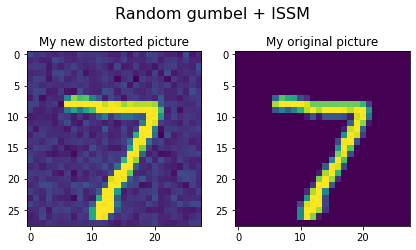

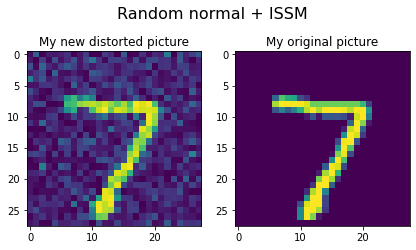

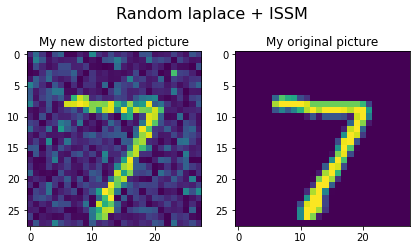

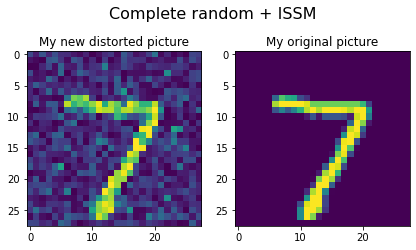

In [135]:
print("Gumbel random fuzzer + ISSM:")
myFuzz = gumbelRandomSSIM(0.005, X_test[0], y_test[0], model_mnist_cnn, 'CNN', 'mnist')
myFuzz.generate()
print(f"It took us {myFuzz.time} seconds")
myFuzz.plot("Random gumbel + ISSM")
print("-------------------------------------------------------")
print("Normal random fuzzer + ISSM:")
myFuzz = normalRandomSSIM(0.005, X_test[0].copy(), y_test[0], model_mnist_cnn, 'CNN', 'mnist')
myFuzz.generate()
print(f"It took us {myFuzz.time} seconds")
myFuzz.plot("Random normal + ISSM")
print("-------------------------------------------------------")
print("Laplace random fuzzer + ISSM:")
myFuzz = laplaceRandomSSIM(0.005, X_test[0].copy(), y_test[0], model_mnist_cnn, 'CNN', 'mnist')
myFuzz.generate()
print(f"It took us {myFuzz.time} seconds")
myFuzz.plot("Random laplace + ISSM")
print("-------------------------------------------------------")
print("Compeletly random fuzzer + ISSM:")
myFuzz = CompeletlyRandomSSIM(0.005, X_test[0].copy(), y_test[0], model_mnist_cnn, 'CNN', 'mnist')
myFuzz.generate()
print(f"It took us {myFuzz.time} seconds")
myFuzz.plot("Complete random + ISSM")
print("-------------------------------------------------------")

In [118]:
model_mnist_ann = load_model("model_mnist_ann.h5")

Gumbel random fuzzer + ISSM:
We found it in iteration number 26
new ID: 8
old ID: 7
It took us 1.331313133239746 seconds
-------------------------------------------------------
Normal random fuzzer + ISSM:
We found it in iteration number 264
new ID: 8
old ID: 7
It took us 13.350984334945679 seconds
-------------------------------------------------------
Laplace random fuzzer + ISSM:
We found it in iteration number 149
new ID: 8
old ID: 7
It took us 7.334331274032593 seconds
-------------------------------------------------------
Compeletly random fuzzer + ISSM:
We found it in iteration number 313
new ID: 8
old ID: 7
It took us 16.421300172805786 seconds
-------------------------------------------------------


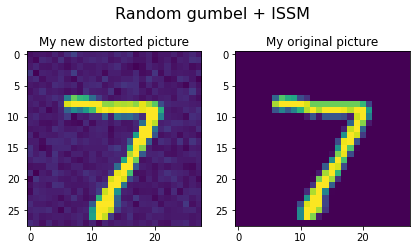

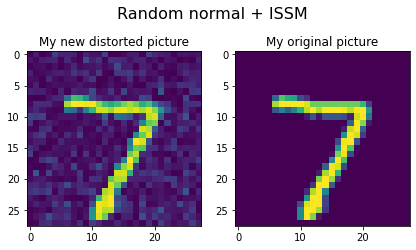

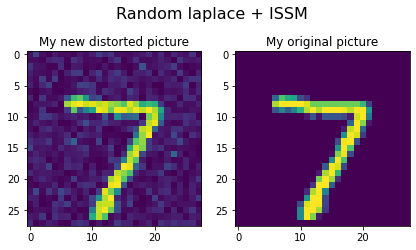

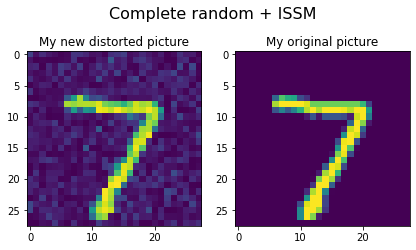

In [133]:
print("Gumbel random fuzzer + ISSM:")
myFuzz = gumbelRandomSSIM(0.005, X_test[0], y_test[0], model_mnist_ann, 'ANN', 'mnist')
myFuzz.generate()
print(f"It took us {myFuzz.time} seconds")
myFuzz.plot("Random gumbel + ISSM")
print("-------------------------------------------------------")
print("Normal random fuzzer + ISSM:")
myFuzz = normalRandomSSIM(0.005, X_test[0].copy(), y_test[0], model_mnist_ann, 'ANN', 'mnist')
myFuzz.generate()
print(f"It took us {myFuzz.time} seconds")
myFuzz.plot("Random normal + ISSM")
print("-------------------------------------------------------")
print("Laplace random fuzzer + ISSM:")
myFuzz = laplaceRandomSSIM(0.005, X_test[0].copy(), y_test[0], model_mnist_ann, 'ANN', 'mnist')
myFuzz.generate()
print(f"It took us {myFuzz.time} seconds")
myFuzz.plot("Random laplace + ISSM")
print("-------------------------------------------------------")
print("Compeletly random fuzzer + ISSM:")
myFuzz = CompeletlyRandomSSIM(0.005, X_test[0].copy(), y_test[0], model_mnist_ann, 'ANN', 'mnist')
myFuzz.generate()
print(f"It took us {myFuzz.time} seconds")
myFuzz.plot("Complete random + ISSM")
print("-------------------------------------------------------")

In [182]:
model_mnist_ann = load_model("model_mnist_ann(2).h5")

Gumbel random fuzzer:
We found it in iteration number 39
new ID: 8
old ID: 7
It took us 2.3477461338043213 seconds
-------------------------------------------------------
Normal random fuzzer:
We found it in iteration number 579
new ID: 8
old ID: 7
It took us 26.73271608352661 seconds
-------------------------------------------------------
Laplace random fuzzer:
We found it in iteration number 380
new ID: 8
old ID: 7
It took us 17.525367975234985 seconds
-------------------------------------------------------
Compeletly random fuzzer:
We found it in iteration number 872
new ID: 8
old ID: 7
It took us 40.363232374191284 seconds
-------------------------------------------------------


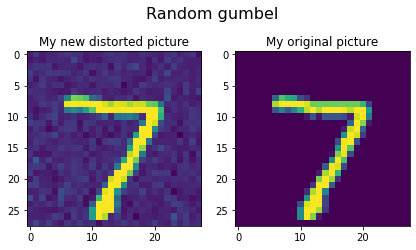

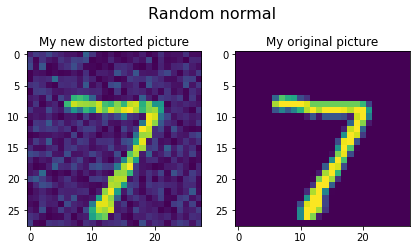

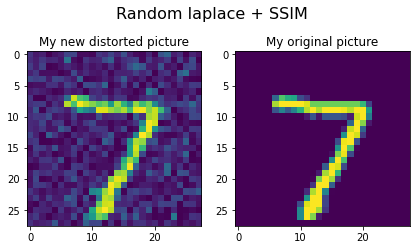

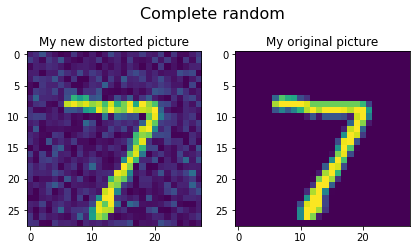

In [187]:
print("Gumbel random fuzzer:")
myFuzz = gumbelRandom(0.005, X_test[0], y_test[0], model_mnist_ann, 'ANN', 'mnist')
myFuzz.generate()
print(f"It took us {myFuzz.time} seconds")
myFuzz.plot("Random gumbel")
print("-------------------------------------------------------")
print("Normal random fuzzer:")
myFuzz = normalRandom(0.005, X_test[0].copy(), y_test[0], model_mnist_ann, 'ANN', 'mnist')
myFuzz.generate()
print(f"It took us {myFuzz.time} seconds")
myFuzz.plot("Random normal")
print("-------------------------------------------------------")
print("Laplace random fuzzer:")
myFuzz = laplaceRandom(0.005, X_test[0].copy(), y_test[0], model_mnist_ann, 'ANN', 'mnist')
myFuzz.generate()
print(f"It took us {myFuzz.time} seconds")
myFuzz.plot("Random laplace + SSIM")
print("-------------------------------------------------------")
print("Compeletly random fuzzer:")
myFuzz = CompeletlyRandom(0.005, X_test[0].copy(), y_test[0], model_mnist_ann, 'ANN', 'mnist')
myFuzz.generate()
print(f"It took us {myFuzz.time} seconds")
myFuzz.plot("Complete random")
print("-------------------------------------------------------")

Gumbel random fuzzer:
We found it in iteration number 50
new ID: 8
old ID: 7
It took us 2.2636706829071045 seconds
-------------------------------------------------------
Normal random fuzzer:
We found it in iteration number 1238
new ID: 8
old ID: 7
It took us 54.893967390060425 seconds
-------------------------------------------------------
Laplace random fuzzer:
We found it in iteration number 446
new ID: 0
old ID: 7
It took us 19.656882286071777 seconds
-------------------------------------------------------
Compeletly random fuzzer:
We found it in iteration number 1901
new ID: 0
old ID: 7
It took us 85.90461230278015 seconds
-------------------------------------------------------


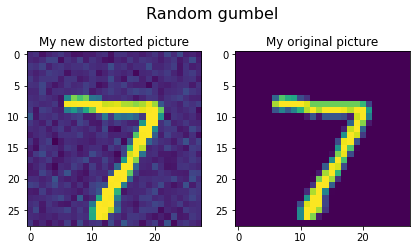

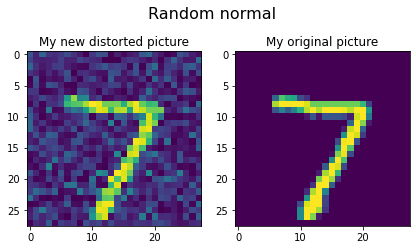

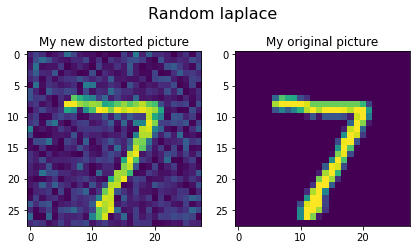

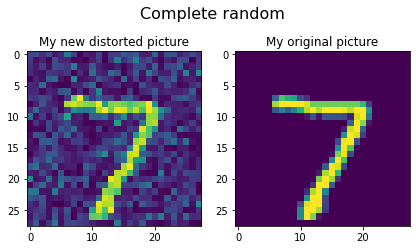

In [196]:
print("Gumbel random fuzzer:")
myFuzz = gumbelRandom(0.005, X_test[0], y_test[0], model_mnist_cnn, 'CNN', 'mnist')
myFuzz.generate()
print(f"It took us {myFuzz.time} seconds")
myFuzz.plot("Random gumbel")
print("-------------------------------------------------------")
print("Normal random fuzzer:")
myFuzz = normalRandom(0.005, X_test[0].copy(), y_test[0], model_mnist_cnn, 'CNN', 'mnist')
myFuzz.generate()
print(f"It took us {myFuzz.time} seconds")
myFuzz.plot("Random normal")
print("-------------------------------------------------------")
print("Laplace random fuzzer:")
myFuzz = laplaceRandom(0.005, X_test[0].copy(), y_test[0], model_mnist_cnn, 'CNN', 'mnist')
myFuzz.generate()
print(f"It took us {myFuzz.time} seconds")
myFuzz.plot("Random laplace")
print("-------------------------------------------------------")
print("Compeletly random fuzzer:")
myFuzz = CompeletlyRandom(0.005, X_test[0].copy(), y_test[0], model_mnist_cnn, 'CNN', 'mnist')
myFuzz.generate()
print(f"It took us {myFuzz.time} seconds")
myFuzz.plot("Complete random")
print("-------------------------------------------------------")

In [211]:
(X_train, y_train), (X_test, y_test), (X_train_Flatten, X_test_Flatten) = preprocess('cifar10')

In [189]:
model_cifar_ann = load_model("model_cifar_ann.h5")

Gumbel random fuzzer:
We found it in iteration number 95
new ID: 5
old ID: 3
It took us 4.4542624950408936 seconds
-------------------------------------------------------
Normal random fuzzer:
We found it in iteration number 7882
new ID: 0
old ID: 3
It took us 358.73847794532776 seconds
-------------------------------------------------------
Laplace random fuzzer:
We found it in iteration number 674
new ID: 4
old ID: 3
It took us 30.9367196559906 seconds
-------------------------------------------------------
Compeletly random fuzzer:
We found it in iteration number 9081
new ID: 4
old ID: 3
It took us 414.69837284088135 seconds
-------------------------------------------------------


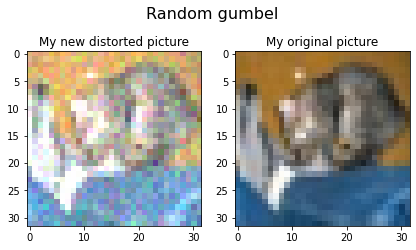

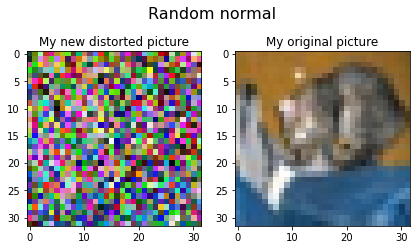

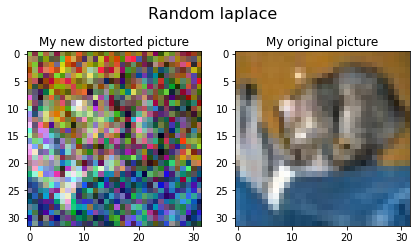

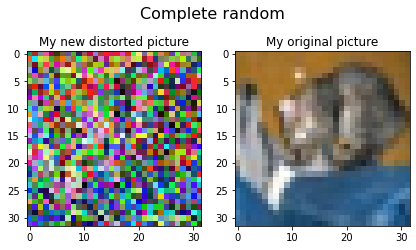

In [192]:
print("Gumbel random fuzzer:")
myFuzz = gumbelRandom(0.005, X_test[0], y_test[0], model_cifar_ann, 'ANN', 'cifar10')
myFuzz.generate()
print(f"It took us {myFuzz.time} seconds")
myFuzz.plot("Random gumbel")
print("-------------------------------------------------------")
print("Normal random fuzzer:")
myFuzz = normalRandom(0.005, X_test[0].copy(), y_test[0], model_cifar_ann, 'ANN', 'cifar10')
myFuzz.generate()
print(f"It took us {myFuzz.time} seconds")
myFuzz.plot("Random normal")
print("-------------------------------------------------------")
print("Laplace random fuzzer:")
myFuzz = laplaceRandom(0.005, X_test[0].copy(), y_test[0], model_cifar_ann, 'ANN', 'cifar10')
myFuzz.generate()
print(f"It took us {myFuzz.time} seconds")
myFuzz.plot("Random laplace")
print("-------------------------------------------------------")
print("Compeletly random fuzzer:")
myFuzz = CompeletlyRandom(0.005, X_test[0].copy(), y_test[0], model_cifar_ann, 'ANN', 'cifar10')
myFuzz.generate()
print(f"It took us {myFuzz.time} seconds")
myFuzz.plot("Complete random")
print("-------------------------------------------------------")

Gumbel random fuzzer:
We found it in iteration number 39
new ID: 2
old ID: 3
It took us 1.8904716968536377 seconds
-------------------------------------------------------
Normal random fuzzer:
We found it in iteration number 62
new ID: 6
old ID: 3
It took us 3.0039196014404297 seconds
-------------------------------------------------------
Laplace random fuzzer:
We found it in iteration number 20
new ID: 6
old ID: 3
It took us 1.0191395282745361 seconds
-------------------------------------------------------
Compeletly random fuzzer:
We found it in iteration number 115
new ID: 6
old ID: 3
It took us 5.552399635314941 seconds
-------------------------------------------------------


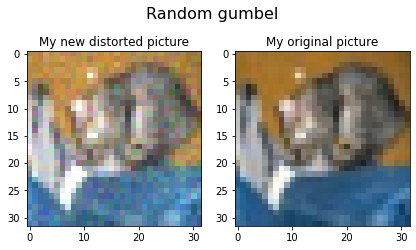

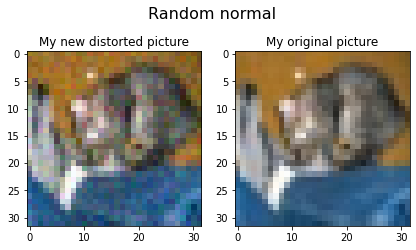

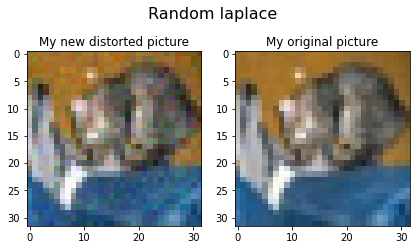

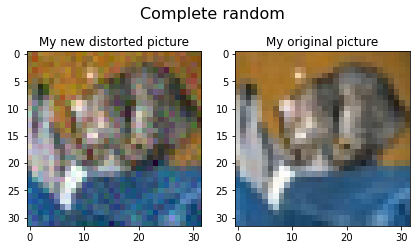

In [193]:
print("Gumbel random fuzzer:")
myFuzz = gumbelRandom(0.005, X_test[0], y_test[0], model_cifar_cnn, 'CNN', 'cifar10')
myFuzz.generate()
print(f"It took us {myFuzz.time} seconds")
myFuzz.plot("Random gumbel")
print("-------------------------------------------------------")
print("Normal random fuzzer:")
myFuzz = normalRandom(0.005, X_test[0].copy(), y_test[0], model_cifar_cnn, 'CNN', 'cifar10')
myFuzz.generate()
print(f"It took us {myFuzz.time} seconds")
myFuzz.plot("Random normal")
print("-------------------------------------------------------")
print("Laplace random fuzzer:")
myFuzz = laplaceRandom(0.005, X_test[0].copy(), y_test[0], model_cifar_cnn, 'CNN', 'cifar10')
myFuzz.generate()
print(f"It took us {myFuzz.time} seconds")
myFuzz.plot("Random laplace")
print("-------------------------------------------------------")
print("Compeletly random fuzzer:")
myFuzz = CompeletlyRandom(0.005, X_test[0].copy(), y_test[0], model_cifar_cnn, 'CNN', 'cifar10')
myFuzz.generate()
print(f"It took us {myFuzz.time} seconds")
myFuzz.plot("Complete random")
print("-------------------------------------------------------")

Gumbel random fuzzer + SSIM:
We found it in iteration number 85
new ID: 5
old ID: 3
It took us 4.445371866226196 seconds
-------------------------------------------------------
Normal random fuzzer + SSIM:
We found it in iteration number 2296
new ID: 5
old ID: 3
It took us 111.63026857376099 seconds
-------------------------------------------------------
Laplace random fuzzer + SSIM:
We found it in iteration number 1647
new ID: 5
old ID: 3
It took us 79.82942986488342 seconds
-------------------------------------------------------
Compeletly random fuzzer + SSIM:
We found it in iteration number 2345
new ID: 1
old ID: 3
It took us 111.88382863998413 seconds
-------------------------------------------------------


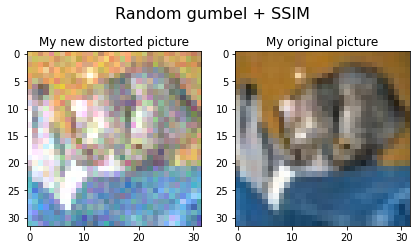

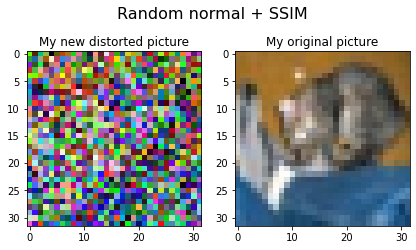

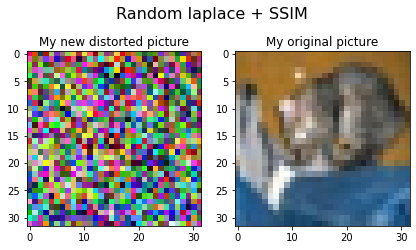

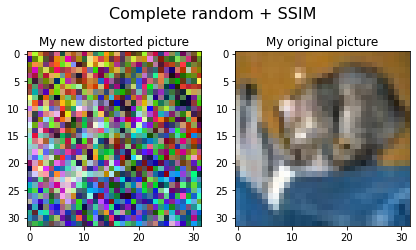

In [149]:
print("Gumbel random fuzzer + SSIM:")
myFuzz = gumbelRandomSSIM(0.005, X_test[0], y_test[0], model_cifar_ann, 'ANN', 'cifar10')
myFuzz.generate()
print(f"It took us {myFuzz.time} seconds")
myFuzz.plot("Random gumbel + SSIM")
print("-------------------------------------------------------")
print("Normal random fuzzer + SSIM:")
myFuzz = normalRandomSSIM(0.005, X_test[0].copy(), y_test[0], model_cifar_ann, 'ANN', 'cifar10')
myFuzz.generate()
print(f"It took us {myFuzz.time} seconds")
myFuzz.plot("Random normal + SSIM")
print("-------------------------------------------------------")
print("Laplace random fuzzer + SSIM:")
myFuzz = laplaceRandomSSIM(0.005, X_test[0].copy(), y_test[0], model_cifar_ann, 'ANN', 'cifar10')
myFuzz.generate()
print(f"It took us {myFuzz.time} seconds")
myFuzz.plot("Random laplace + SSIM")
print("-------------------------------------------------------")
print("Compeletly random fuzzer + SSIM:")
myFuzz = CompeletlyRandomSSIM(0.005, X_test[0].copy(), y_test[0], model_cifar_ann, 'ANN', 'cifar10')
myFuzz.generate()
print(f"It took us {myFuzz.time} seconds")
myFuzz.plot("Complete random + SSIM")
print("-------------------------------------------------------")

In [110]:
model_cifar_cnn = load_model("model_cifar_cnn.h5")

Gumbel random fuzzer + SSIM:
We found it in iteration number 51
new ID: 2
old ID: 3
It took us 3.681975841522217 seconds
-------------------------------------------------------
Normal random fuzzer + SSIM:
We found it in iteration number 67
new ID: 6
old ID: 3
It took us 3.3268778324127197 seconds
-------------------------------------------------------
Laplace random fuzzer + SSIM:
We found it in iteration number 74
new ID: 2
old ID: 3
It took us 3.629228353500366 seconds
-------------------------------------------------------
Compeletly random fuzzer + SSIM:
We found it in iteration number 163
new ID: 2
old ID: 3
It took us 7.919776678085327 seconds
-------------------------------------------------------


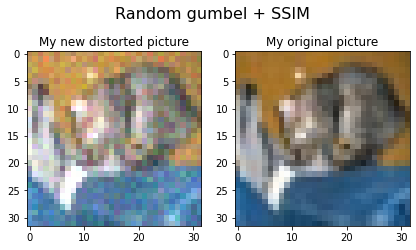

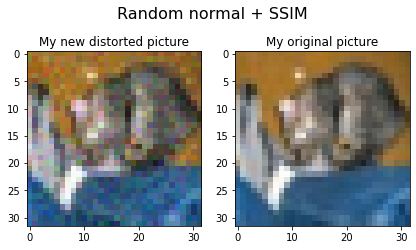

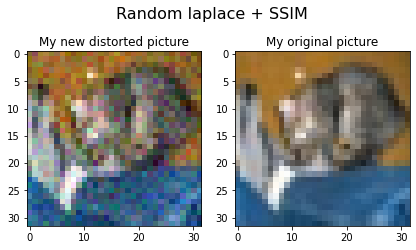

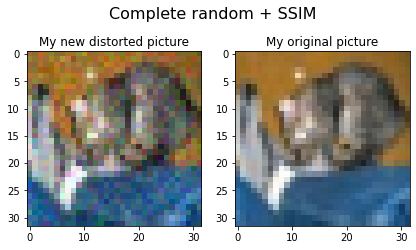

In [111]:
print("Gumbel random fuzzer + SSIM:")
myFuzz = gumbelRandomSSIM(0.005, X_test[0], y_test[0], model_cifar_cnn, 'CNN', 'cifar10')
myFuzz.generate()
print(f"It took us {myFuzz.time} seconds")
myFuzz.plot("Random gumbel + SSIM")
print("-------------------------------------------------------")
print("Normal random fuzzer + SSIM:")
myFuzz = normalRandomSSIM(0.005, X_test[0].copy(), y_test[0], model_cifar_cnn, 'CNN', 'cifar10')
myFuzz.generate()
print(f"It took us {myFuzz.time} seconds")
myFuzz.plot("Random normal + SSIM")
print("-------------------------------------------------------")
print("Laplace random fuzzer + SSIM:")
myFuzz = laplaceRandomSSIM(0.005, X_test[0].copy(), y_test[0], model_cifar_cnn, 'CNN', 'cifar10')
myFuzz.generate()
print(f"It took us {myFuzz.time} seconds")
myFuzz.plot("Random laplace + SSIM")
print("-------------------------------------------------------")
print("Compeletly random fuzzer + SSIM:")
myFuzz = CompeletlyRandomSSIM(0.005, X_test[0].copy(), y_test[0], model_cifar_cnn, 'CNN', 'cifar10')
myFuzz.generate()
print(f"It took us {myFuzz.time} seconds")
myFuzz.plot("Complete random + SSIM")
print("-------------------------------------------------------")

In [134]:
model_mnist_cnn = load_model("model_mnist_cnn.h5")

In [150]:
(X_train, y_train), (X_test, y_test), (X_train_Flatten, X_test_Flatten) = preprocess('cifar10')

In [151]:
model_mnist_ann = load_model("model_cifar_cnn.h5")

Gumbel random fuzzer + SSIM:
We found it in iteration number 52
new ID: 2
old ID: 3
It took us 2.747931718826294 seconds
-------------------------------------------------------
Normal random fuzzer + SSIM:
We found it in iteration number 75
new ID: 6
old ID: 3
It took us 3.850802421569824 seconds
-------------------------------------------------------
Laplace random fuzzer + SSIM:
We found it in iteration number 26
new ID: 6
old ID: 3
It took us 1.4039366245269775 seconds
-------------------------------------------------------
Compeletly random fuzzer + SSIM:
We found it in iteration number 119
new ID: 6
old ID: 3
It took us 6.274894714355469 seconds
-------------------------------------------------------


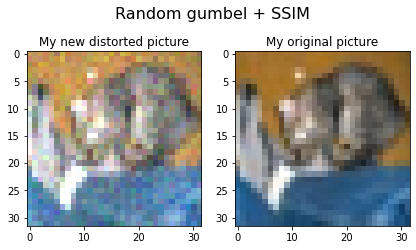

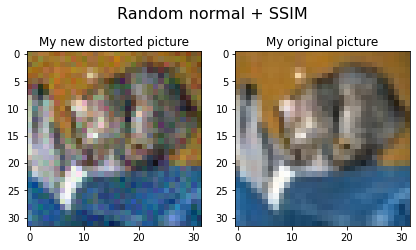

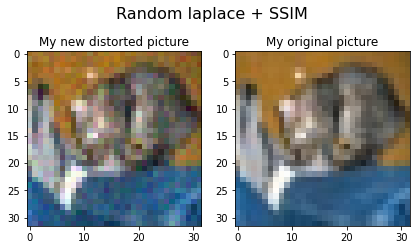

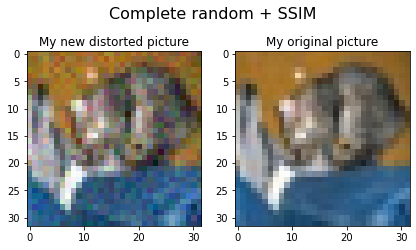

In [152]:
print("Gumbel random fuzzer + SSIM:")
myFuzz = gumbelRandomSSIM(0.005, X_test[0], y_test[0], model_cifar_cnn, 'CNN', 'cifar10')
myFuzz.generate()
print(f"It took us {myFuzz.time} seconds")
myFuzz.plot("Random gumbel + SSIM")
print("-------------------------------------------------------")
print("Normal random fuzzer + SSIM:")
myFuzz = normalRandomSSIM(0.005, X_test[0].copy(), y_test[0], model_cifar_cnn, 'CNN', 'cifar10')
myFuzz.generate()
print(f"It took us {myFuzz.time} seconds")
myFuzz.plot("Random normal + SSIM")
print("-------------------------------------------------------")
print("Laplace random fuzzer + SSIM:")
myFuzz = laplaceRandomSSIM(0.005, X_test[0].copy(), y_test[0], model_cifar_cnn, 'CNN', 'cifar10')
myFuzz.generate()
print(f"It took us {myFuzz.time} seconds")
myFuzz.plot("Random laplace + SSIM")
print("-------------------------------------------------------")
print("Compeletly random fuzzer + SSIM:")
myFuzz = CompeletlyRandomSSIM(0.005, X_test[0].copy(), y_test[0], model_cifar_cnn, 'CNN', 'cifar10')
myFuzz.generate()
print(f"It took us {myFuzz.time} seconds")
myFuzz.plot("Complete random + SSIM")
print("-------------------------------------------------------")

In [141]:
model_cifar_ann = load_model("model_cifar_ann.h5")

Gumbel random fuzzer + SSIM:
We found it in iteration number 96
new ID: 5
old ID: 3
It took us 4.726914405822754 seconds
-------------------------------------------------------
Normal random fuzzer + SSIM:
We found it in iteration number 1728
new ID: 5
old ID: 3
It took us 88.13212275505066 seconds
-------------------------------------------------------
Laplace random fuzzer + SSIM:
We found it in iteration number 937
new ID: 4
old ID: 3
It took us 46.4696991443634 seconds
-------------------------------------------------------
Compeletly random fuzzer + SSIM:
We found it in iteration number 1537
new ID: 4
old ID: 3
It took us 76.53051018714905 seconds
-------------------------------------------------------


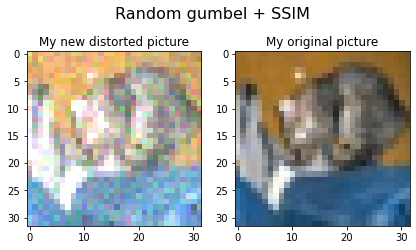

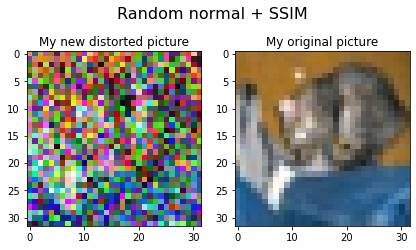

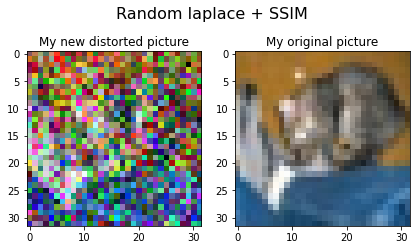

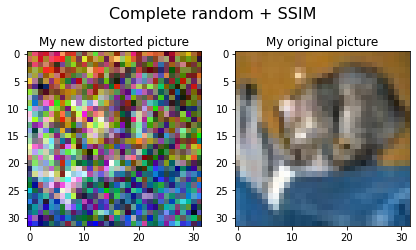

In [153]:
print("Gumbel random fuzzer + SSIM:")
myFuzz = gumbelRandomSSIM(0.005, X_test[0], y_test[0], model_cifar_ann, 'ANN', 'cifar10')
myFuzz.generate()
print(f"It took us {myFuzz.time} seconds")
myFuzz.plot("Random gumbel + SSIM")
print("-------------------------------------------------------")
print("Normal random fuzzer + SSIM:")
myFuzz = normalRandomSSIM(0.005, X_test[0].copy(), y_test[0], model_cifar_ann, 'ANN', 'cifar10')
myFuzz.generate()
print(f"It took us {myFuzz.time} seconds")
myFuzz.plot("Random normal + SSIM")
print("-------------------------------------------------------")
print("Laplace random fuzzer + SSIM:")
myFuzz = laplaceRandomSSIM(0.005, X_test[0].copy(), y_test[0], model_cifar_ann, 'ANN', 'cifar10')
myFuzz.generate()
print(f"It took us {myFuzz.time} seconds")
myFuzz.plot("Random laplace + SSIM")
print("-------------------------------------------------------")
print("Compeletly random fuzzer + SSIM:")
myFuzz = CompeletlyRandomSSIM(0.005, X_test[0].copy(), y_test[0], model_cifar_ann, 'ANN', 'cifar10')
myFuzz.generate()
print(f"It took us {myFuzz.time} seconds")
myFuzz.plot("Complete random + SSIM")
print("-------------------------------------------------------")

Gumbel random fuzzer:
We found it in iteration number 83
new ID: 8
old ID: 3
It took us 4.023447275161743 seconds
-------------------------------------------------------
Normal random fuzzer:
We found it in iteration number 3064
new ID: 4
old ID: 3
It took us 145.3455147743225 seconds
-------------------------------------------------------
Laplace random fuzzer:
We found it in iteration number 6034
new ID: 0
old ID: 3
It took us 286.0141956806183 seconds
-------------------------------------------------------
Compeletly random fuzzer:
We found it in iteration number 552
new ID: 4
old ID: 3
It took us 26.438631057739258 seconds
-------------------------------------------------------


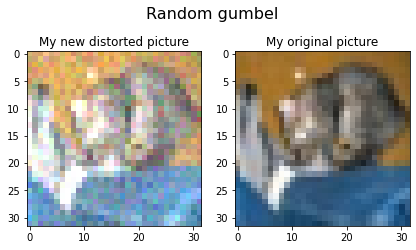

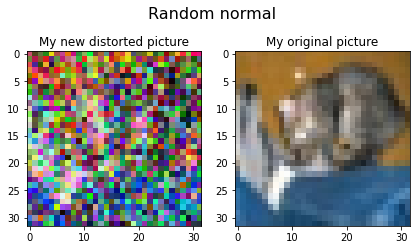

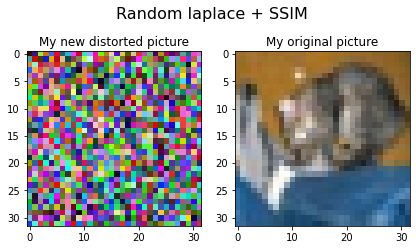

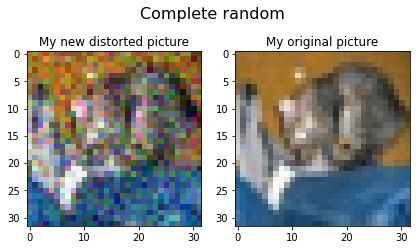

In [156]:
print("Gumbel random fuzzer:")
myFuzz = gumbelRandom(0.005, X_test[0], y_test[0], model_cifar_ann, 'ANN', 'cifar10')
myFuzz.generate()
print(f"It took us {myFuzz.time} seconds")
myFuzz.plot("Random gumbel")
print("-------------------------------------------------------")
print("Normal random fuzzer:")
myFuzz = normalRandom(0.005, X_test[0].copy(), y_test[0], model_cifar_ann, 'ANN', 'cifar10')
myFuzz.generate()
print(f"It took us {myFuzz.time} seconds")
myFuzz.plot("Random normal")
print("-------------------------------------------------------")
print("Laplace random fuzzer:")
myFuzz = laplaceRandom(0.005, X_test[0].copy(), y_test[0], model_cifar_ann, 'ANN', 'cifar10')
myFuzz.generate()
print(f"It took us {myFuzz.time} seconds")
myFuzz.plot("Random laplace + SSIM")
print("-------------------------------------------------------")
print("Compeletly random fuzzer:")
myFuzz = CompeletlyRandom(0.005, X_test[0].copy(), y_test[0], model_cifar_ann, 'ANN', 'cifar10')
myFuzz.generate()
print(f"It took us {myFuzz.time} seconds")
myFuzz.plot("Complete random")
print("-------------------------------------------------------")

Gumbel random fuzzer:
We found it in iteration number 68
new ID: 2
old ID: 3
It took us 3.4064691066741943 seconds
-------------------------------------------------------
Normal random fuzzer:
We found it in iteration number 56
new ID: 6
old ID: 3
It took us 2.85127854347229 seconds
-------------------------------------------------------
Laplace random fuzzer:
We found it in iteration number 33
new ID: 6
old ID: 3
It took us 1.7415568828582764 seconds
-------------------------------------------------------
Compeletly random fuzzer:
We found it in iteration number 174
new ID: 2
old ID: 3
It took us 8.637136459350586 seconds
-------------------------------------------------------


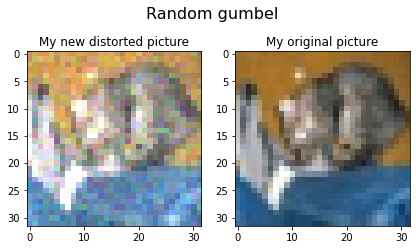

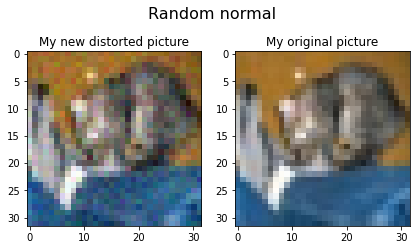

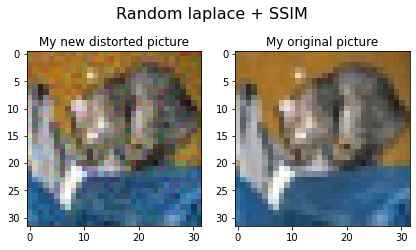

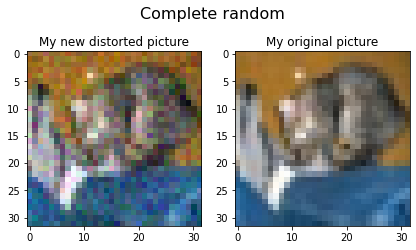

In [157]:
print("Gumbel random fuzzer:")
myFuzz = gumbelRandom(0.005, X_test[0], y_test[0], model_cifar_cnn, 'CNN', 'cifar10')
myFuzz.generate()
print(f"It took us {myFuzz.time} seconds")
myFuzz.plot("Random gumbel")
print("-------------------------------------------------------")
print("Normal random fuzzer:")
myFuzz = normalRandom(0.005, X_test[0].copy(), y_test[0], model_cifar_cnn, 'CNN', 'cifar10')
myFuzz.generate()
print(f"It took us {myFuzz.time} seconds")
myFuzz.plot("Random normal")
print("-------------------------------------------------------")
print("Laplace random fuzzer:")
myFuzz = laplaceRandom(0.005, X_test[0].copy(), y_test[0], model_cifar_cnn, 'CNN', 'cifar10')
myFuzz.generate()
print(f"It took us {myFuzz.time} seconds")
myFuzz.plot("Random laplace + SSIM")
print("-------------------------------------------------------")
print("Compeletly random fuzzer:")
myFuzz = CompeletlyRandom(0.005, X_test[0].copy(), y_test[0], model_cifar_cnn, 'CNN', 'cifar10')
myFuzz.generate()
print(f"It took us {myFuzz.time} seconds")
myFuzz.plot("Complete random")
print("-------------------------------------------------------")